In [0]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

In [0]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [0]:
iv3 = InceptionV3()

In [18]:
print(iv3.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [0]:
from keras.preprocessing import image

In [24]:
!wget "https://wakyma.com/blog/wp-content/uploads/2017/10/Tipos-de-diarrea-en-gatos-y-su-tratamiento-770x460."
!wget "https://www.telesurtv.net/__export/1533261002478/sites/telesur/img/multimedia/2018/07/31/cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg"

--2018-12-28 19:18:19--  https://wakyma.com/blog/wp-content/uploads/2017/10/Tipos-de-diarrea-en-gatos-y-su-tratamiento-770x460.
Resolving wakyma.com (wakyma.com)... 52.209.125.33
Connecting to wakyma.com (wakyma.com)|52.209.125.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32549 (32K) [application/octet-stream]
Saving to: ‘Tipos-de-diarrea-en-gatos-y-su-tratamiento-770x460..3’

Tipos-de-diarrea-en 100%[===================>]  31.79K  --.-KB/s    in 0s      

2018-12-28 19:18:20 (190 MB/s) - ‘Tipos-de-diarrea-en-gatos-y-su-tratamiento-770x460..3’ saved [32549/32549]

--2018-12-28 19:18:21--  https://www.telesurtv.net/__export/1533261002478/sites/telesur/img/multimedia/2018/07/31/cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg
Resolving www.telesurtv.net (www.telesurtv.net)... 190.185.106.220, 131.108.40.130, 179.63.248.14
Connecting to www.telesurtv.net (www.telesurtv.net)|190.185.106.220|:443... connected.
HTTP request sent, awaiting response

[[('n02823750', 'beer_glass', 0.9819864),
  ('n02815834', 'beaker', 0.0041335677),
  ('n07930864', 'cup', 0.0013360069),
  ('n04560804', 'water_jug', 0.0012402353),
  ('n03950228', 'pitcher', 0.0009487012)]]

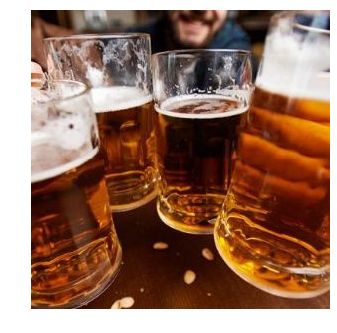

In [28]:
img = image.load_img("cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg", target_size=(299,299))
x = image.img_to_array(img)

plt.axis('off')
plt.imshow(img)


# cambio de rango de 0,255 a -1,1
x = ((x/255.0)-0.5)*2

x = x.reshape(1,x.shape[0],x.shape[1],x.shape[2])

y = iv3.predict(x)

decode_predictions(y)

# Ataques adversarios

In [26]:
# interceptar el nodo de entrada y la capa de salida
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

# numero correspondiente a un limon
target_class = 951

loss = out_layer[0, target_class]
grad = K.gradients(loss, inp_layer)[0]
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])
adv = np.copy(x)

pert = 0.01
min_pert = x - pert
max_pert = x + pert

cost = 0.0

while cost<0.95:
  
  gr, cost = optimize_gradient([adv,0])
  adv += gr
  adv = np.clip(adv, min_pert, max_pert)
  adv = np.clip(adv, -1, 1)
  print("target cost: ",cost)
  
  

target cost:  9.2293776e-05
target cost:  9.331861e-05
target cost:  9.436456e-05
target cost:  9.544393e-05
target cost:  9.6547454e-05
target cost:  9.765732e-05
target cost:  9.878543e-05
target cost:  9.995047e-05
target cost:  0.00010113949
target cost:  0.00010234907
target cost:  0.00010359152
target cost:  0.0001048772
target cost:  0.00010619943
target cost:  0.00010754658
target cost:  0.000108916494
target cost:  0.00011032608
target cost:  0.000111760295
target cost:  0.00011321604
target cost:  0.00011469228
target cost:  0.000116197116
target cost:  0.000117757336
target cost:  0.00011936662
target cost:  0.00012100865
target cost:  0.00012268095
target cost:  0.00012441287
target cost:  0.00012620293
target cost:  0.00012805098
target cost:  0.00012994188
target cost:  0.00013188321
target cost:  0.00013388903
target cost:  0.00013596159
target cost:  0.00013806645
target cost:  0.0001402121
target cost:  0.00014242534
target cost:  0.00014469522
target cost:  0.00014705

cer_apo.jpg
cer_apo.jpg.1
cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg
cerveza_hack.png
sample_data
santa-cerveza.jpg
Tipos-de-diarrea-en-gatos-y-su-tratamiento-770x460.
Tipos-de-diarrea-en-gatos-y-su-tratamiento-770x460..1
Tipos-de-diarrea-en-gatos-y-su-tratamiento-770x460..2
Tipos-de-diarrea-en-gatos-y-su-tratamiento-770x460..3


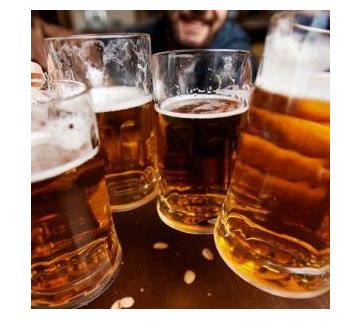

In [30]:

adv_hack2 = ((adv/2.0)+0.5)*255
adv_hack2 = adv_hack2[0].astype(np.uint8)
plt.axis('off')
plt.imshow(adv_hack2)

pred_img = image.array_to_img(adv_hack2)
pred_img.save('cerveza_hack.png')



In [36]:
img_hack = image.load_img("cerveza_hack.png")
x_hack = image.img_to_array(img_hack)



# cambio de rango de 0,255 a -1,1
x_hack = ((x_hack/255.0)-0.5)*2

x_hack = x_hack.reshape(1,x_hack.shape[0],x_hack.shape[1],x_hack.shape[2])

y_hack = iv3.predict(x_hack)

decode_predictions(y_hack)

[[('n07749582', 'lemon', 0.9945893),
  ('n07747607', 'orange', 0.0031315216),
  ('n03062245', 'cocktail_shaker', 0.00016349535),
  ('n02823750', 'beer_glass', 0.00013405082),
  ('n03530642', 'honeycomb', 0.00010935171)]]